# Network Metrics

1. **Basic Graph Stats**

   size (number of nodes, number of edges)

   density (number of edges compared to fully connected graph | ratio of actual to possible edge)
   
2. **Degree Metrics**

   average degree (how many clusters each cluster is connected to | number of neighbours of a node (cluster))

   average weighted degree (how strong/frequent those connections are)

3. **Connectedness** (Local & Global)

   Clustering coefficient (average clustering) (how likely neighboring clusters are also connected)



   Connected Components (cc) (counts how many disconnected groups exist | unified vs. fragmented network)

       * reachability: in cc, all the nodes are always reachable from each other

   Diameter (of largest component) (how far apart are the two most distant clusters (in terms of longest shortest path))

4. **Modularity** (Community Structure)

   Louvain algo to detect communities (cluster groups)

   modularity score to measure how well separated those communities are

5. **Centrality Measures**

   degree centrality (importance by number of connections)

   betweenness centrality (importance as a bridge in network flow)

6. **Top Nodes by Centrality**

    top 5 nodes by degree centrality

    top 5 nodes by betweenness centrality

7. **Top Strongest Edges**

   most frequently co-occurring cluster pairs by sorting edges by weight (in original list of edges)

pairs: e.g "Depression" cluster for female connected to "Reproduction Health" cluster vs.  (what is for male?)

## Main Script: Metrics

In [29]:
import json
import os
import pandas as pd
import networkx as nx
import numpy as np

import community.community_louvain as community_louvain # import Louvain algo for community detection (calculate modularity)
import matplotlib.pyplot as plt
from collections import Counter

base_dir = os.path.abspath("..")

# General Pattern
# file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "cluster_co-occurrence_edges.json")
# output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "network_analysis", "network_stats.json")

# Demographics
file_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "gender")
output_path = os.path.join(base_dir, "data", "bipartite_network", "general_patterns", "demographics", "network_analysis", "network_stats.json")

# # Community-Specific Patterns
# file_path = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "cluster_co-occurrence_edges_by_comm")
# output_path = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "network_analysis", "network_stats.json")

def load_graph(json_path):
    # Load edge list ( {"source": "Hematology & Blood Disorders", "target": "Procedures, Surgeries & Medical Devices", "weight": 2}
    with open(json_path, "r", encoding = "utf-8") as f:
        edges = json.load(f)
        
    G = nx.Graph()

    # Load the edge list into a weighted (undirected) graph
    for entry in edges:
        u = entry["source"]  # source node (cluster)
        v = entry["target"]  # target node (cluster)
        w = entry["weight"]
        G.add_edge(u, v, weight = w)
        
    return G

def analyze_graph(G, label):
    analysis = {}  # store graph's stats

    # 1. Basic stats
    analysis["label"] = label
    analysis["nodes"] = G.number_of_nodes()  # number of nodes (clusters) in a graph
    analysis["edges"] = G.number_of_edges()
    analysis["density"] = nx.density(G)  # [0-1] number of edges compared to fully connected graph (ratio of actual to all possible connections)
    # 0 -> sparse; 1 -> fully connected

    # 2. Degree
    degrees = dict(G.degree())  # number of neighbours of a node (cluster)
    weighted_degrees = dict(G.degree(weight="weight"))  # sum of egde weights
    analysis["average_degree"] = np.mean(list(degrees.values())) # how many (avg) other clusters is auch cluster connected to
    analysis["average_weighted_degree"] = np.mean(list(weighted_degrees.values()))  # how frequent (strong) are these connections btw clusters

    # 3. Connectedness of a graph (local (Clustering Coefficient) & globally (Connected Components)
    
    # 3.1 Clustering Coefficient (how often neighbours of a node (cluster) are connected)
    # If cluster A is connected to B and C, how likely that B and C are connected too?
    clustering = nx.clustering(G, weight="weight")
    analysis["average_clustering"] = np.mean(list(clustering.values()))  # avg across all nodes (cluster)

    # 3.2 Connected Components (cc) (see how many disconnected groups of clusters a graph has: a graph is unified or fragmented)
    # reachability: in connected components, all the nodes are always reachable from each other
    components = list(nx.connected_components(G))
    largest_cc = max(components, key=len)  # largest cc
    analysis["num_components"] = len(components) # total number of cc ( 1 if everything is connected)
    analysis["largest_component_size"] = len(largest_cc) # how many nodes (clusters) are in the largest group
    
    # 3.3 Diameter (the longest shortest path btw any 2 nodes (clusters) in a cc) -> computer diameter of the largest_cc
    G_largest_cc = G.subgraph(largest_cc)
    if nx.is_connected(G_largest_cc):
        analysis["diameter"] = nx.diameter(G_largest_cc)  # nx.diameter works on cc
    else:
        analysis["diameter"] = "Not connected"
    

    # 4. Modularity ( [0-1] how well a graph can be divided into communities (groups of closely connected nodes))
    # 1 if the detected communities are well separated
    # 0 if mixed up
    partition = community_louvain.best_partition(G)  # Louvain algo to detect communities
    analysis["modularity"] = community_louvain.modularity(partition, G)
    
    # 5. Centrlity Measures (nodes (clusters) of importance)
    degree_centrality = nx.degree_centrality(G)  # nodes with most connections
    betweenness_centrality = nx.betweenness_centrality(G, weight="weight")  # what clusters serve as bridges between others (nodes most important for information flow)
    
    # 6. Top (n=5) nodes for each centrality measure
    analysis["top5_degree_centrality"] = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]  # dictionary; descending order
    analysis["top5_betweenness_centrality"] = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]  # dictionary; descending order

    # 7. Top 5 strongest edges (cluster pairs that co-occurre most frequently across profiles)
    # insted of looking which cluster has the highest degree, we look into what pairs are most connected
    # get the edge with the biggest weight and get the corresponding clusters of that "heavy" edge
    # essentially: sort the original (json) list of edges by weights and get top (n=5) cluster-PAIRS (main point are pairs)

    # UPDATED: instead of including absolute weight, save relative percentage of frequencies    
    total_weight = sum(d["weight"] for _, _, d in G.edges(data=True))  # total weight of all edges

    strongest_edges = sorted(G.edges (data=True), key=lambda x: x[2]["weight"], reverse=True)[:5]  # list of tuples; descending order
    analysis["top5_cluster_pairs_by_weight"] = [(u, v, int((w["weight"] / total_weight)*100)) for u, v, w in strongest_edges]  # u - source, v - target cluster

    return analysis
    
# Load the contents of the network_stats.json file (if exists)
if os.path.exists(output_path):
    with open(output_path, "r", encoding="utf-8") as f:
        results = json.load(f)
else:
    results = {}
    
# Extract group label from dir name
group_label = os.path.basename(os.path.normpath(file_path))  # "UK - US"

# if group_label not in results:
results[group_label] = []

### -------- For General Patterns only (not demographics)
# file = file_path 
# label = os.path.splitext(os.path.basename(file))[0] 
# path_current = os.path.join(file_path, file)

# G = load_graph(path_current)  # load JSON files (edges) as graphs
# stats = analyze_graph(G, label)  # analyze graphs

# results[group_label].append(stats)
### -----------------------------------------------------

### -------- For general patterns (demographics) & Community-Specific Pattern 
for file in os.listdir(file_path):
    if file.endswith(".json") and not file.startswith("pms"):
        label = file.replace(".json", "")
        path_current = os.path.join(file_path, file)
        
        G = load_graph(path_current)  # load JSON files (edges) as graphs
        stats = analyze_graph(G, label)  # analyze graphs
        
        results[group_label].append(stats)
# -------------------------------------------------------------------------------

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)

print(f"\nNetwork stats saved to: {output_path}")

summary_df = pd.DataFrame(results[group_label])
summary_df



Network stats saved to: C:\Users\NASTYA\code\tum-thesis\data\bipartite_network\general_patterns\demographics\network_analysis\network_stats.json


,label,nodes,edges,density,average_degree,average_weighted_degree,average_clustering,num_components,largest_component_size,diameter,modularity,top5_degree_centrality,top5_betweenness_centrality,top5_cluster_pairs_by_weight
0,cluster_co-occurrence_female,23,252,0.996047,21.913043,1749.565217,0.042498,1,23,2,0.046766,"[(Hematology & Blood Disorders, 1.0), (Mental ...","[(Rare Diseases & Genetic Disorders, 0.6666666...",[(Reproductive & Sexual Health (Women's Health...
1,cluster_co-occurrence_male,23,232,0.916996,20.173913,603.826087,0.033270,1,23,2,0.059647,"[(Mental Health & Emotional Wellbeing, 1.0), (...","[(Rare Diseases & Genetic Disorders, 0.3429292...",[(Reproductive & Sexual Health (Women's Health...


In [21]:
summary_df["top5_cluster_pairs_by_weight"].to_list()

[[('Lifestyle, Diet & Supplements',
   "Reproductive & Sexual Health (Women's Health & Men's Health)",
   11),
  ('Lifestyle, Diet & Supplements', 'Mental Health & Emotional Wellbeing', 10),
  ("Reproductive & Sexual Health (Women's Health & Men's Health)",
   'Mental Health & Emotional Wellbeing',
   9),
  ('Neurological Disorders', 'Mental Health & Emotional Wellbeing', 5),
  ('Lifestyle, Diet & Supplements', 'Neurological Disorders', 3)],
 [('Lifestyle, Diet & Supplements',
   "Reproductive & Sexual Health (Women's Health & Men's Health)",
   8),
  ('Lifestyle, Diet & Supplements', 'Mental Health & Emotional Wellbeing', 6),
  ("Reproductive & Sexual Health (Women's Health & Men's Health)",
   'Mental Health & Emotional Wellbeing',
   5),
  ('Neurological Disorders', 'Mental Health & Emotional Wellbeing', 2),
  ('Lifestyle, Diet & Supplements', 'Neurological Disorders', 2)],
 [('Lifestyle, Diet & Supplements',
   "Reproductive & Sexual Health (Women's Health & Men's Health)",
   7),


## Community-Specific Patterns

### Top Clusters (across Communities)
how often each of the 23 clusters appears in the top N=5 cluster pairs across all communities

We want to know for each cluster (e.g. “Reproductive & Sexual Health”), how often it appears in:
the top 1 cluster pair,
the top 2 cluster pairs.
...
up to top 5 cluster pairs

across all community networks

**how often different health-related clusters appear in the top 5 most important co-occurring cluster pairs in each community**

Saved to:
C:\Users\NASTYA\code\tum-thesis\data\bipartite_network\community-specific_patterns\network_analysis\top_clusters_across_comm.json


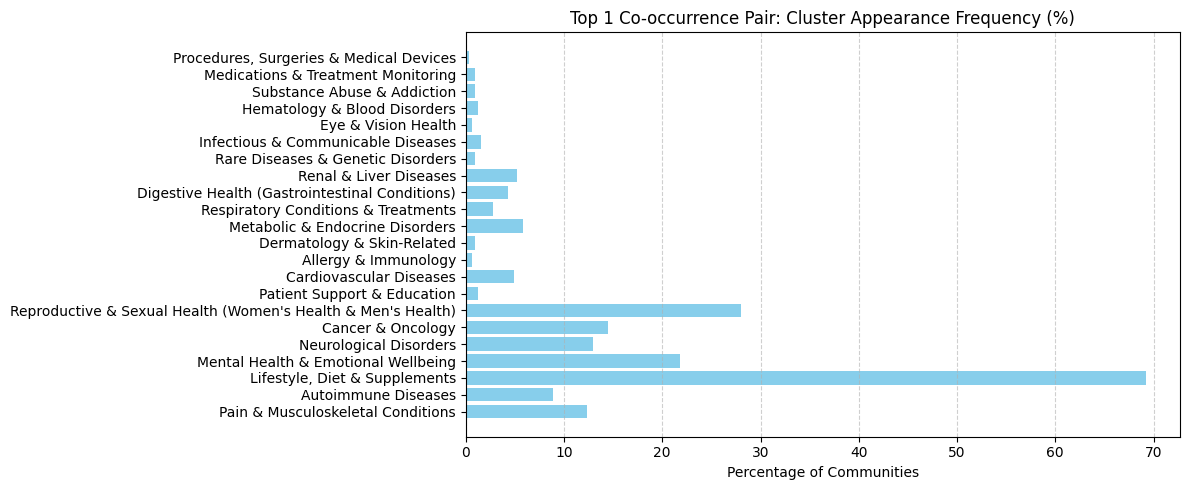

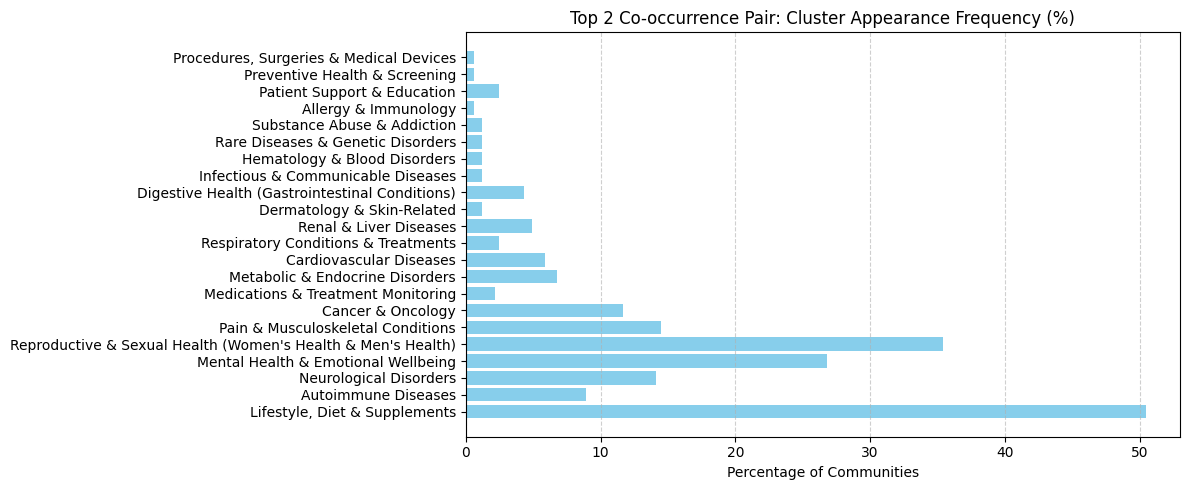

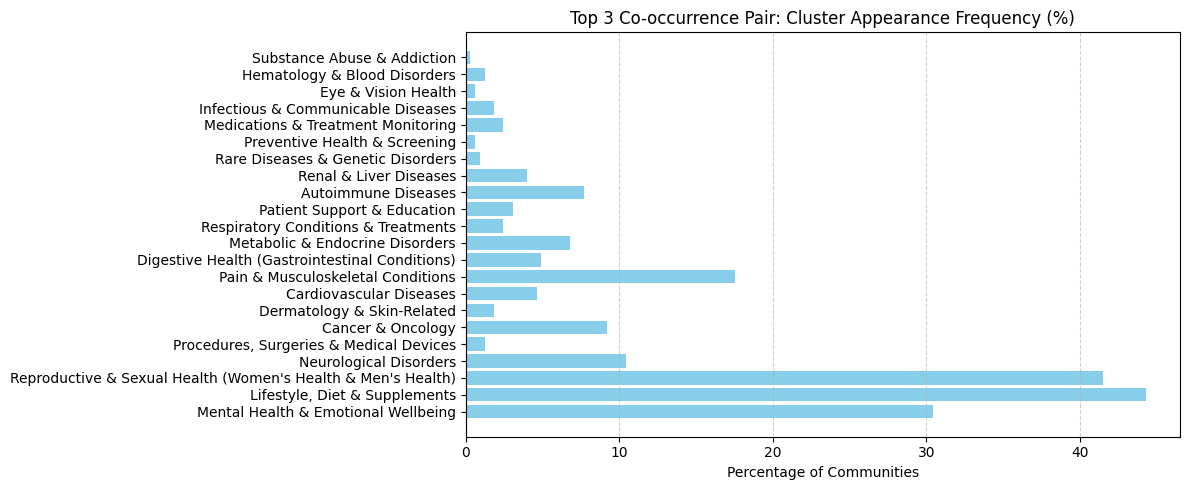

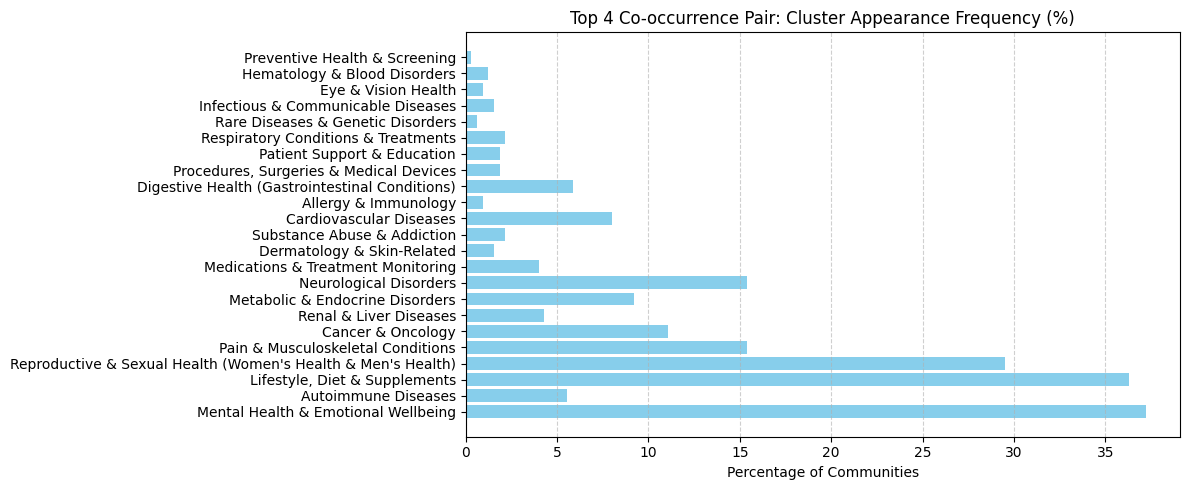

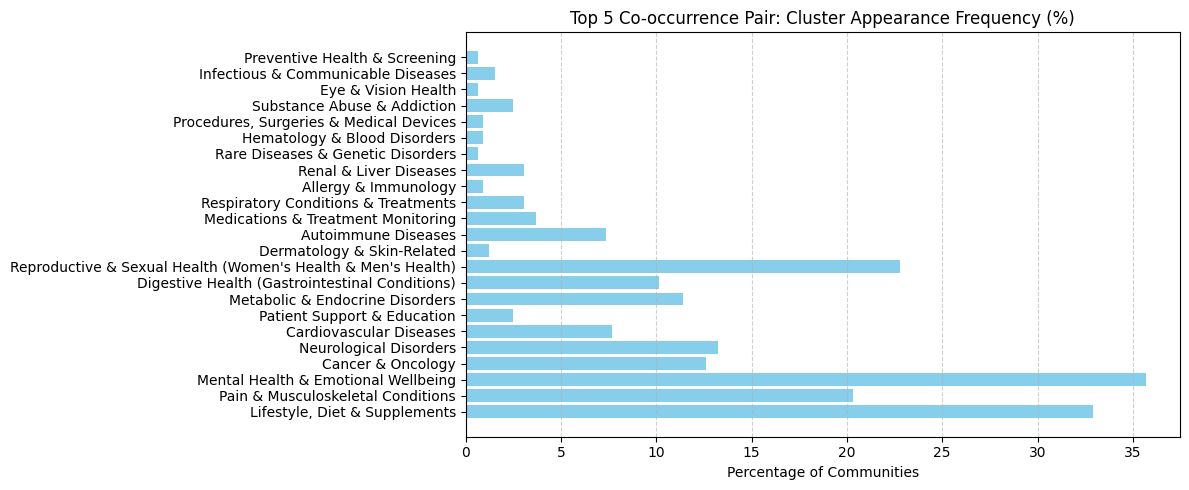

In [2]:
import json
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

base_dir = os.path.abspath("..")

file_path = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "network_analysis", "network_stats.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "network_analysis", "top_clusters_across_comm.json")

with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# How often each cluster appears in top-N positions
top_n_occurrences = {rank: Counter() for rank in range(1, 6)}

for community_stats in data.values():
    for stats in community_stats:
        pairs = stats.get("top5_cluster_pairs_by_weight", [])
        for i, (c1, c2, _) in enumerate(pairs[:5]):
            rank = i + 1
            top_n_occurrences[rank][c1] += 1
            top_n_occurrences[rank][c2] += 1

# Normalize by total number of communities
total_communities = sum(len(stats) for stats in data.values())

top_n_percentages = {
    rank: {
        cluster: round((count / total_communities) * 100, 2)
        for cluster, count in counter.items()
    }
    for rank, counter in top_n_occurrences.items()
}

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(top_n_percentages, f, indent=2)

print(f"Saved to:\n{output_path}")

# Plot cluster appearance % for each rank
for rank in range(1, 6):
    cluster_freqs = top_n_percentages[rank]
    clusters = list(cluster_freqs.keys())
    percentages = list(cluster_freqs.values())

    plt.figure(figsize=(12, 5))
    plt.barh(clusters, percentages, color='skyblue')
    plt.title(f"Top {rank} Co-occurrence Pair: Cluster Appearance Frequency (%)")
    plt.xlabel("Percentage of Communities")
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    # plt.show()


#### Show in 1 Plot: How frequently different health-related clusters appear in the Top 1 to Top 5 most weighted co-occurrence cluster pairs, across all communities.

x-axis: cluster
y-axis: %of communitied (communities networks), where a cluster appears in Top-N most weighted (strongest) co-occurrence cluster pairs.

E.g. if Mental Health has a bar height of 35% for Rank 1, that means it was in the strongest co-occurrence pair in 35% of all communities.

**Rank 1-2** -> It's a core cluster across communities.
**Rank 4–5** -> Important, but less central in most networks.
**Consistent** bars across all ranks -> Broad and stable co-occurrence relevance.

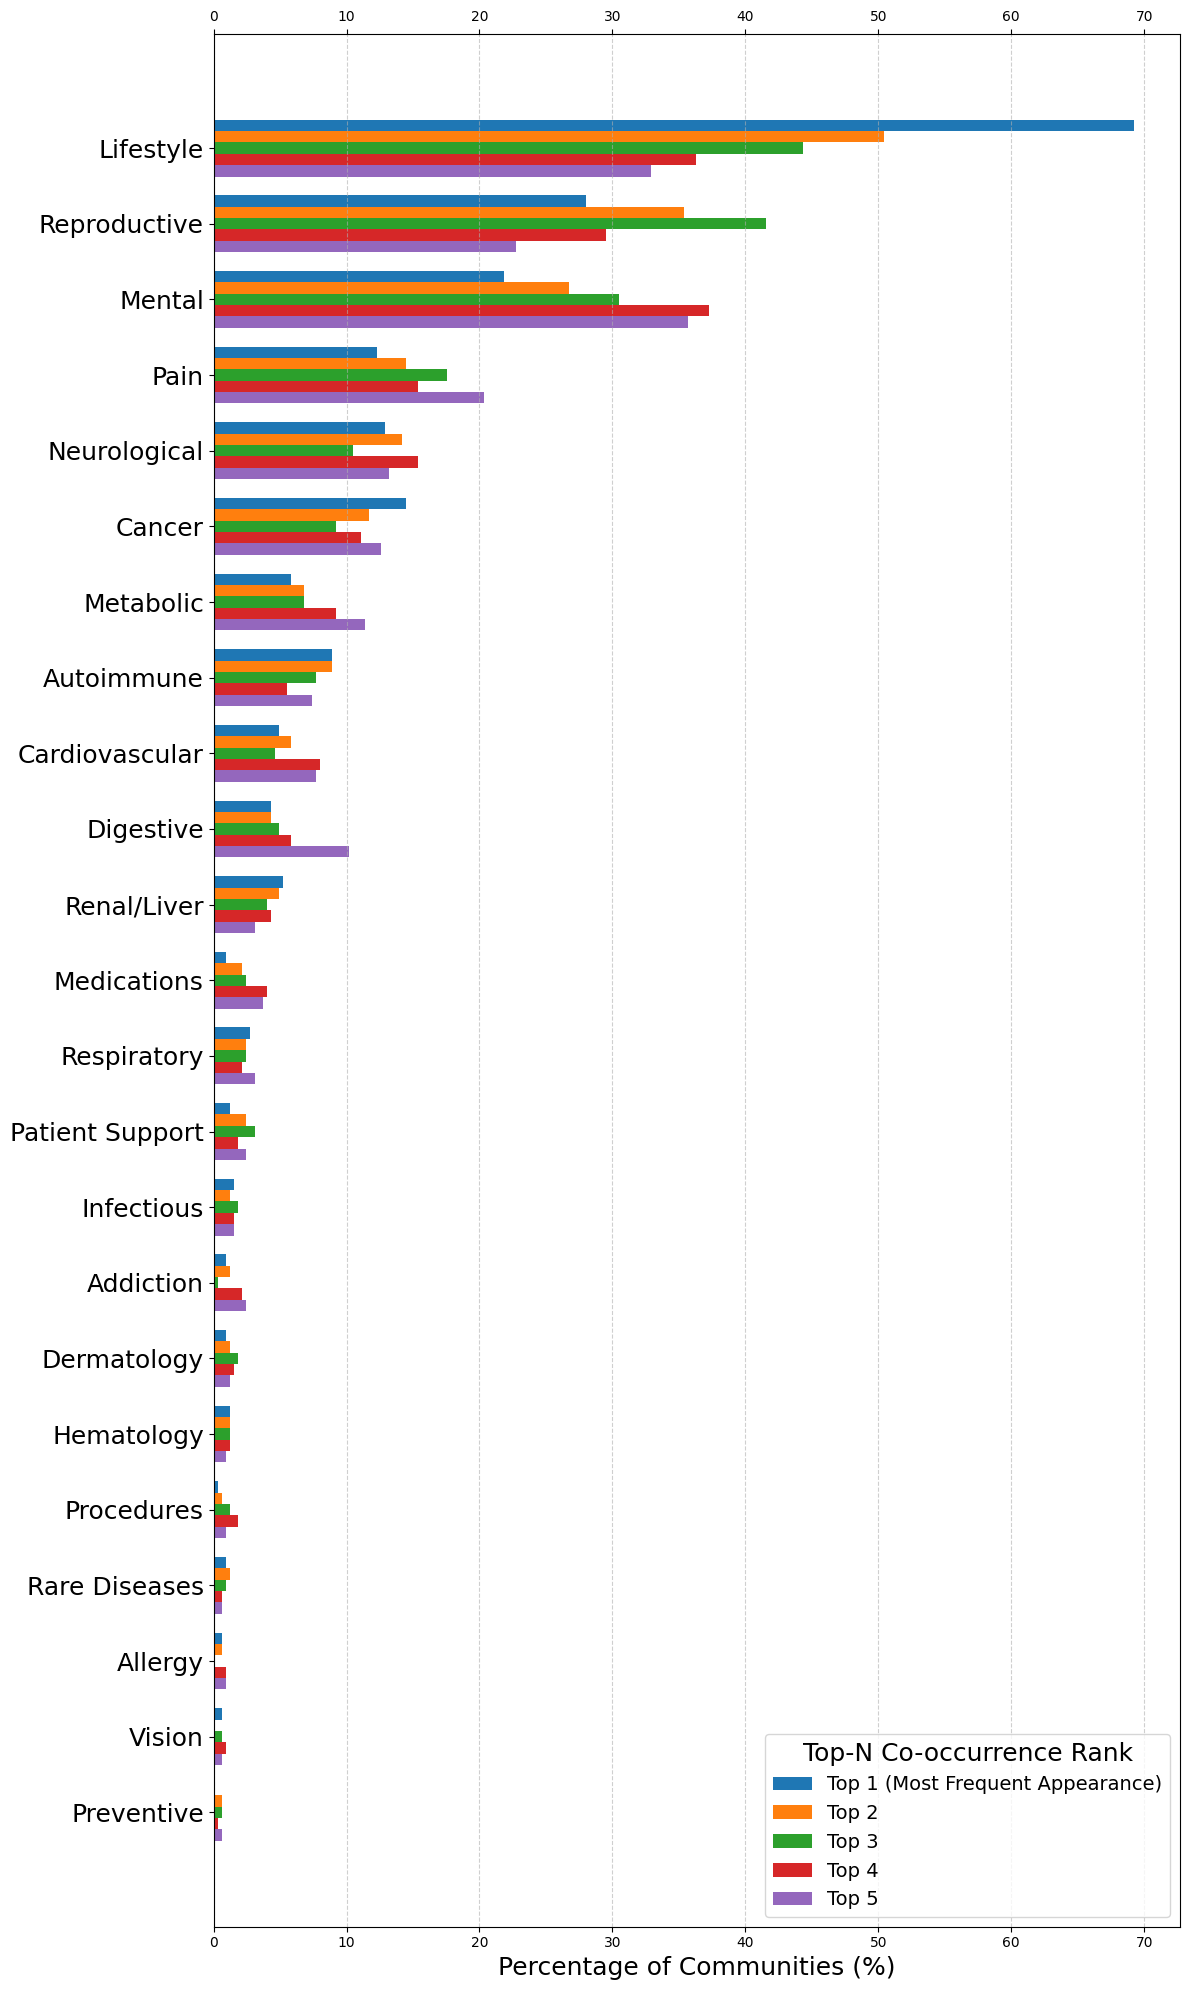

In [11]:
import numpy as np

# Cluster name abbreviations
cluster_abbreviations = {
    "Medications & Treatment Monitoring": "Medications",
    "Cancer & Oncology": "Cancer",
    "Neurological Disorders": "Neurological",
    "Pain & Musculoskeletal Conditions": "Pain",
    "Mental Health & Emotional Wellbeing": "Mental",
    "Digestive Health (Gastrointestinal Conditions)": "Digestive",
    "Cardiovascular Diseases": "Cardiovascular",
    "Reproductive & Sexual Health (Women's Health & Men's Health)": "Reproductive",
    "Lifestyle, Diet & Supplements": "Lifestyle",
    "Metabolic & Endocrine Disorders": "Metabolic",
    "Respiratory Conditions & Treatments": "Respiratory",
    "Dermatology & Skin-Related": "Dermatology",
    "Autoimmune Diseases": "Autoimmune",
    "Eye & Vision Health": "Vision",
    "Renal & Liver Diseases": "Renal/Liver",
    "Infectious & Communicable Diseases": "Infectious",
    "Hematology & Blood Disorders": "Hematology",
    "Preventive Health & Screening": "Preventive",
    "Allergy & Immunology": "Allergy",
    "Substance Abuse & Addiction": "Addiction",
    "Procedures, Surgeries & Medical Devices": "Procedures",
    "Rare Diseases & Genetic Disorders": "Rare Diseases",
    "Patient Support & Education": "Patient Support"
}

# Get all clusters from all Top-N ranks (from above);  top_n_percentages (dict) {1: {"Cluster A": 0.89, ...}, 2: {...}, ..., 5: {...}}
# Collect all keys (cluster names) from each rank's dictionary
all_clusters = sorted(set().union(*[set(d.keys()) for d in top_n_percentages.values()]))

# Merges into a set of unique clusters

# Get total appearance frequency (across all Top-N ranks) for sorting
# Sum appearance percentages of each cluster across Top 1 to Top 5 (if "Cluster A" is not present in Top-i, set to 0)
total_appearance = {
    cluster: sum(top_n_percentages[rank].get(cluster, 0) for rank in range(1, 6))
    for cluster in all_clusters
}
# SORT clusters by TOTAL appearance (desc)
clusters_sorted = sorted(all_clusters, key=lambda c: total_appearance[c], reverse=True)
abbreviated_clusters_sorted = [cluster_abbreviations.get(c, c) for c in clusters_sorted]

# Group by rank, order according to sorted clusters
rank_values = []
for rank in range(1, 6):
    rank_values.append([top_n_percentages[rank].get(cluster, 0) for cluster in clusters_sorted])

# Plot
x = np.arange(len(abbreviated_clusters_sorted)) # cluster's location in x-axis
width = 0.15  # width of the bars

fig, ax = plt.subplots(figsize=(12, 20))  # horizontal layout

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
labels = ['Top 1 (Most Frequent Appearance)', 'Top 2', 'Top 3', 'Top 4', 'Top 5']

y = np.arange(len(abbreviated_clusters_sorted))
height = 0.15  # height of each bar segment

for i in range(5):
    ax.barh(y + i * height, [v for v in rank_values[i]], height, label=labels[i], color=colors[i])

ax.set_xlabel('Percentage of Communities (%)', fontsize=18)
ax.set_yticks(y + 2 * height)
ax.set_yticklabels(abbreviated_clusters_sorted, fontsize=18)
ax.invert_yaxis()  # show highest values at the top

ax.tick_params(axis='x', labeltop=True, top=True, labelbottom=True, bottom=True)

ax.legend(title='Top-N Co-occurrence Rank', fontsize=14, title_fontsize=18)
ax.grid(True, axis='x', linestyle='--', alpha=0.6) # vertical gridlines

plt.tight_layout()  # avoid label cut-offs

plt.savefig("top_cluster_appearance_by_rank.svg", format='svg', dpi=300, bbox_inches='tight')

plt.show()

### (Opposite) Top Communities (for each Cluster)

1) for each cluster, find top N (N=5,10) communities they are coming (appearing) from (by frequency)

2) in how many and in which communities, a  cluster, e.g. “Mental”, was part of top 5 clusters? dont care about rank (like top 1 , top 2) here

#### 1. Find top N (N=5,10) communities a cluster appears in (by frequency)
#### 2. For a specific cluster, find get ALL communties it appears in

In [24]:
import json
import os
from collections import defaultdict, Counter

base_dir = os.path.abspath("..")

file_path = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "network_analysis", "network_stats.json")
output_path = os.path.join(base_dir, "data", "bipartite_network", "community-specific_patterns", "network_analysis", "top_comm_per_cluster.json")

with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)
    all_communities = data["cluster_co-occurrence_edges_by_comm"]

# Map each cluster to the list of communities where it appears
cluster_to_communities = defaultdict(list)

for comm in all_communities:
    community_name = comm["label"]
    for pair in comm.get("top5_cluster_pairs_by_weight", []):
        c1, c2, _ = pair
        cluster_to_communities[c1].append(community_name)
        cluster_to_communities[c2].append(community_name)

# Construct final structured output
top_comm_per_cluster = []
for cluster, communities in cluster_to_communities.items():
    total_freq = len(set(communities))  # unique community count
    community_counter = Counter(communities)
    top10 = community_counter.most_common(10)
    unique_communities = sorted(set(communities))
    
    top_comm_per_cluster.append({
        "cluster": cluster,
        "total_appearance_frequency": total_freq,
        "top10_communities": top10,
        "all_communities": unique_communities
    })

# Save
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(top_comm_per_cluster, f, indent=2, ensure_ascii=False)

Saved to:
C:\Users\NASTYA\code\tum-thesis\data\bipartite_network\community-specific_patterns\network_analysis\top_comm_per_cluster.json
